In [0]:
%pip install -U -q langgraph langchain_community langchain-openai langchain_experimental

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
%pip install python-dotenv

In [0]:
%pip install -U -q  wikipedia

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


# Import

In [0]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import create_react_agent
from typing import Literal, Annotated
from typing_extensions import TypedDict
from IPython.display import display, Image
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import os
import operator
import wikipedia

# LLM config

In [0]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [0]:
llm = ChatOpenAI(model="gpt-4o-mini")

# State

In [0]:
class State(MessagesState):
    next: str
    knowledge: str
    question: str

# Manager Agent

In [0]:
members = ["researcher", "writer"]

options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

In [0]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["researcher", "writer", "FINISH"]

In [0]:
def manager_node(state: State) -> Command[Literal["researcher", "writer", "__end__"]]:
    print("********MANAGER AGENT********")
    user_query = state["messages"][0].content
    print(user_query)
    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"]
    print("********MANAGER AGENT: INPUT********")
    print(messages)
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print("********MANAGER AGENT: RESPONSE********")
    print(response)
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto, "question": user_query})

# Researcher Agent

In [0]:
def get_wiki_data(topic):
    data = wikipedia.summary(topic)
    return data

class WikipediaTopic(BaseModel):
  topic: str = Field(description="The wikipedia article topic to search")

@tool(args_schema = WikipediaTopic)
def wikipedia_search(topic: str) -> str:
  """Returns the summary of wikipedia page of the passed topic"""
  return get_wiki_data(topic)

In [0]:
tools = [wikipedia_search]
tools_names = {t.name: t for t in tools}
llm_with_tools = llm.bind_tools(tools)

In [0]:
def research_node(state: State) -> Command[Literal["manager"]]:
    print("******RESEARCHER AGENT******")
    question = state["question"]
    query = [HumanMessage(question)]
    print("******RESEARCHER AGENT: INPUT******")
    print(question)
    result = llm_with_tools.invoke(query)
    tool_calls = result.tool_calls
    tool_messages = []
    for t in tool_calls:

      if not t['name'] in tools_names:
        result = "Error: There's no such tool, please try again"
      else:
        print(f"EXECUTING TOOL: {t['name']}")
        print(f"ARGS: {t['args']}")
        result = tools_names[t['name']].invoke(t['args'])

        tool_messages.append(
          ToolMessage(
            tool_call_id=t['id'],
            name=t['name'],
            content=str(result)
          )
        )
    print("******RESEARCHER AGENT: RESPONSE******")
    knowledge = tool_messages[-1].content
    print(knowledge)    
    return Command(
        update={
            "messages": [
                AIMessage(content=knowledge, name="researcher")
            ],
            "knowledge": knowledge
        },
        goto="manager",
    )

# Writer Chain

In [0]:
system_writer_prompt = (
    """You are the Writer agent in a multi-agent system. Your role is to generate a clear, well-structured, and informative answer using the content provided by other agents, especially the Researcher.
    
    Use this information to write a coherent and complete answer to the user's original question. Be concise but thorough, and make sure the explanation flows logically."""
)

write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_writer_prompt),
        (
            "human","""Here is question and the base content to help you to generate the answer for the question:\n\n, 
            QUESTION: \n\n{question}\n
            BASE CONTENT: \n\n{knowledge}"""
        ),
    ]
)

writer_chain = write_prompt | llm | StrOutputParser()

def writer_node(state: State) -> Command[Literal["manager"]]:
    print("******WRITER AGENT******")
    knowledge = state['knowledge']
    question = state['question']
    response = writer_chain.invoke({"knowledge":knowledge, "question":question})
    print("******WRITER AGENT: RESPONSE******")
    print(response)

    return Command(update={
            "messages": [
                HumanMessage(content=knowledge),
                AIMessage(content=response, name="writer")
            ]
        },
        goto="manager"
    )

In [0]:
write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_writer_prompt),
        (
            "human","""Here is question and the base content to help you to generate the answer for the question:\n\n, 
            QUESTION: \n\n{question}\n
            BASE CONTENT: \n\n{knowledge}"""
        ),
    ]
)

In [0]:
writer_chain = write_prompt | llm | StrOutputParser()

In [0]:
def writer_node(state: State) -> Command[Literal["manager"]]:
    print("******WRITER AGENT******")
    knowledge = state['knowledge']
    question = state['question']
    response = writer_chain.invoke({"knowledge":knowledge, "question":question})
    print("******WRITER AGENT: RESPONSE******")
    print(response)

    return Command(update={
            "messages": [
                HumanMessage(content=knowledge),
                AIMessage(content=response, name="writer")
            ]
        },
        goto="manager"
    )

# Graph

In [0]:
builder = StateGraph(State)
builder.add_edge(START, "manager")
builder.add_node("manager", manager_node)
builder.add_node("researcher", research_node)
builder.add_node("writer", writer_node)
graph = builder.compile()

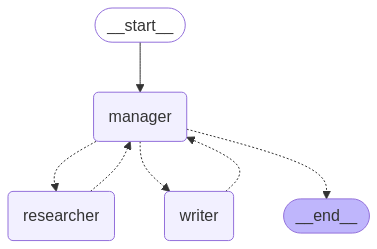

In [0]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Chat Workflow

In [0]:
messages = [HumanMessage(content="I need an article explaining how artificial intelligence is being applied in medicine, with current data and examples. Please research reliable sources if necessary before writing the text.")]
result = graph.invoke({"messages": messages})
result

********MANAGER AGENT********
I need an article explaining how artificial intelligence is being applied in medicine, with current data and examples. Please research reliable sources if necessary before writing the text.
********MANAGER AGENT: INPUT********
[{'role': 'system', 'content': "You are a supervisor tasked with managing a conversation between the following workers: ['researcher', 'writer']. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH."}, HumanMessage(content='I need an article explaining how artificial intelligence is being applied in medicine, with current data and examples. Please research reliable sources if necessary before writing the text.', additional_kwargs={}, response_metadata={}, id='1a955dd2-f3a8-4694-a1dd-ef0d72cadd1c')]
********MANAGER AGENT: RESPONSE********
{'next': 'researcher'}
******RESEARCHER AGENT******
******RESEARCHER A

{'messages': [HumanMessage(content='I need an article explaining how artificial intelligence is being applied in medicine, with current data and examples. Please research reliable sources if necessary before writing the text.', additional_kwargs={}, response_metadata={}, id='1a955dd2-f3a8-4694-a1dd-ef0d72cadd1c'),
  AIMessage(content='Artificial intelligence (AI) has been used in applications throughout industry and academia. In a manner analogous to electricity or computers, AI serves as a general-purpose technology. AI programs are designed to simulate human perception and understanding. These systems are capable of adapting to new information and responding to changing situations. Machine learning has been used for various scientific and commercial purposes including language translation, image recognition, decision-making, credit scoring, and e-commerce.\n\n', additional_kwargs={}, response_metadata={}, name='researcher', id='59da9eb2-e752-40b3-943b-855be4d74eb0'),
  HumanMessage(c